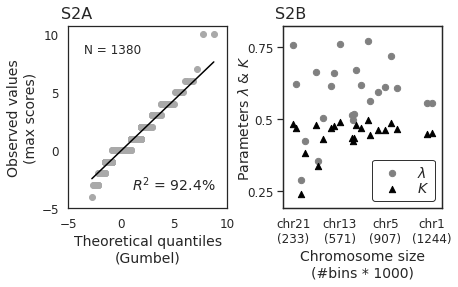

In [1]:
%matplotlib inline

import os as os
import collections as col
import pickle as pck
import json as js

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stat

# What does this do?
# Plot a single summary plot
# of all maximal HSPs / their
# fit to a Gumbel distribution
# and the estimates of the KA
# parameters relative to the
# chromosome size

# cache date for non-random
# maximal scores
#date = '20180921'
date = '20181004'

run_plot_gumbel_fit = True

save_figures = True
diss_version = False

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

np.seterr('raise')

journal = 'bmc_genbio'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

scorings = ['penem', 'ordem', 'penrep', 'ordrep']
segmentations = ['cmm18', 'ecs18', 'ecs10']

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

dataset_root = os.path.join(fhgfs_base, 'sciddo', 'deep')

base_out = '/TL/epigenetics2/work/pebert/cloud/mpiinf/phd/chapter_projects/statediff'

fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')

fig_diss = '/home/pebert/work/code/mpggit/dissertation/Figures/diffchrom'


def collect_block_maxima(root_path, cache_file):
    
    for root, dirs, datafiles in os.walk(root_path):
        #if root.endswith('hsp_run'):
        if root.endswith('baseline_run'):
            for df in datafiles:
                fpath = os.path.join(root, df)
                parts = df.split('.')[0].split('_')
                seg = parts[2]
                score = 'penem'
                #seg, score, c1, _, c2 = parts[2:]
                #comp = c1 + '_vs_' + c2
                idx, vals = [], []
                with pd.HDFStore(fpath, 'r') as hdf:
                    #key_prefix = os.path.join('/segments', score)
                    key_prefix = os.path.join('/raw_scan', score)
                    load_keys = [k for k in hdf.keys() if k.startswith(key_prefix)]
                    for k in load_keys:
                        chrom = os.path.split(k)[-1]
                        #block_max = hdf[k]['nat_score_lnorm'].max()
                        # for random sampling, only maximal scores
                        # are stored in the run dataset
                        block_max = hdf[k]['nat_score_lnorm']
                        idx.append(chrom)
                        vals.append(block_max)
                store_path = os.path.join('block_max', seg, score, 'random_sample')
                max_vals = np.concatenate(vals)
                #max_vals = np.array(list(set(max_vals)), dtype=np.float64)
                with pd.HDFStore(cache_file, 'a') as hdf:
                    #hdf.put(store_path, pd.Series(vals, index=idx, dtype=np.int32))
                    hdf.put(store_path, pd.Series(max_vals, dtype=np.int32))
    return cache_file


def collect_ka_params(root_path, cache_file):
    
    for root, dirs, datafiles in os.walk(root_path):
        for df in datafiles:
            if root.endswith('baseline_run'):
                continue
            if df.startswith('sciddo-data') and df.endswith('.h5'):
                fpath = os.path.join(root, df)
                parts = df.split('.')[0].split('_')
                seg = parts[2]
                with pd.HDFStore(fpath, 'r') as hdf:
                    chrom = hdf['/metadata/chromosomes']
                    chrom = chrom.loc[:, ['bins']]
                                        
                    load_keys = [k for k in hdf.keys() if k.startswith('/scoring') and
                                 k.endswith('/parameters')]
                    for k in load_keys:
                        scoring = k.split('/')[2]
                        p = hdf[k]
                        p = p.loc[:, ['ka_h', 'ka_k', 'ka_lambda']]
                        
                        mrg = pd.concat([chrom, p], axis=1, ignore_index=False, sort=False)
                        
                        store_path = os.path.join('ka_params', seg, scoring)
                        with pd.HDFStore(cache_file, 'a') as cache:
                            cache.put(store_path, mrg, format='table')
    return cache_file
                    

def make_diag_plot(blockmax, params, fkey, save_diss):
    """
    """
    
    fig, (ax_gumbel, ax_param) = plt.subplots(figsize=fig_sizes['two_col']['half'],
                                              nrows=1, ncols=2, sharex=False, sharey=False)
    
    plt.subplots_adjust(wspace=0.35)
    
    est_param = stat.gumbel_r.fit(blockmax.values)
    (osm, osr), (slope, inter, cod) = stat.probplot(blockmax.values, est_param,
                                                    dist='gumbel_r', fit=True,
                                                    plot=ax_gumbel)
    
    # markers
    ax_gumbel.get_lines()[0].set_color('darkgrey')
    # trendline
    ax_gumbel.get_lines()[1].set_color('black')
    ax_gumbel.set_xlabel('Theoretical quantiles\n(Gumbel)', fontsize=14)
    ax_gumbel.set_ylabel('Observed values\n(max scores)', fontsize=14)
    ax_gumbel.get_xaxis().set_ticks([-5, 0, 5, 10])
    ax_gumbel.get_yaxis().set_ticks([-5, 0, 5, 10])
    ax_gumbel.get_xaxis().set_tick_params(labelsize=12)
    ax_gumbel.get_yaxis().set_tick_params(labelsize=12)
    ax_gumbel.text(x=0.1, y=0.85, s='N = {}'.format(blockmax.size),
                   fontdict={'fontsize': 12}, transform=ax_gumbel.transAxes)
    if save_diss:
        tt = ax_gumbel.set_title('', fontsize=16)
    else:
        tt = ax_gumbel.set_title(fkey + 'A', fontsize=16)
        tt.set_position((0.05, 1.01))
    
    # returned "cod" is square root, square again...
    cod = str(np.round(cod**2 * 100, 1))
    ax_gumbel.text(0.4, 0.1, '$R^2$ = ' + cod + '%', fontsize=14, transform=ax_gumbel.transAxes)
    
    # ========================
    
    x = params['bins'].astype(np.int32)
    y_limits = []
    for p, m, c in zip(['ka_lambda', 'ka_k'],
                       ['o', '^'], ['grey', 'black']):
        y = params[p]
        y_limits.append(y.max())
        y_limits.append(y.min())
        
        _, _, r_value, _, _ = stat.linregress(x,y)
        if p == 'ka_lambda':
            v = '\lambda'
        else:
            v = 'K'
        #label = '${}$: $R^2$={}%'.format(v, np.round(r_value**2 * 100, 1))
        label = '${}$'.format(v)
        
        ax_param.scatter(x, y, s=40, marker=m, color=c,
                         label=label)
    
    #ax_param.legend(loc='lower right', fontsize=14,
    #                bbox_to_anchor=(1, -0.01), markerfirst=True,
    #                frameon=True, labelspacing=0.1, borderpad=0.1,
    #                handletextpad=0.01, edgecolor='black',
    #                borderaxespad=0.3, facecolor=None)
    ax_param.legend(loc='lower right', fontsize=14, markerfirst=True,
                    frameon=True, labelspacing=0.1, edgecolor='black')
        
    y_limits = min(y_limits), max(y_limits)
    ax_param.set_ylim(y_limits[0] - 0.05, y_limits[1] + 0.05)
    
    yticks = [0.25, 0.5, 0.75]
    ax_param.set_yticks(yticks)
    ax_param.set_yticklabels(map(str, yticks), fontsize=12)
    ax_param.set_ylabel('Parameters $\lambda$ & $K$', fontsize=14,
                        labelpad=-5)
    
    x_chroms = ['chr21', 'chr13', 'chr5', 'chr1']
    xticks = params.loc[x_chroms, 'bins']
    xticklabels = [c + '\n({})'.format(int(b / 1000)) for c, b in zip(x_chroms, xticks)]
    ax_param.set_xticks(xticks)
    ax_param.set_xticklabels(xticklabels, fontsize=12)
    ax_param.set_xlabel('Chromosome size\n(#bins * 1000)', fontsize=14)
    
    if not save_diss:
        tt = ax_param.set_title(fkey + 'B', fontsize=16)
        tt.set_position((0.05, 1.01))
    
    ax_param2 = ax_param.twinx()
    ax_param2.set_yticks([])
                   
    return fig, []
    
    
def plot_hsp_gumbel_fit():
    cache_file = os.path.join(cache_dir, '{}_plot_gumbel-fit_ka-params.h5'.format(date))
    #os.unlink(cache_file)
    if not os.path.isfile(cache_file):
        cache_file = collect_ka_params(dataset_root, cache_file)
        cache_file = collect_block_maxima(dataset_root, cache_file)
    
    seg = 'cmm18'
    score = 'penem'
    with pd.HDFStore(cache_file, 'r') as hdf:
        right_panel = hdf['ka_params/{}/{}'.format(seg, score)]
        left_collect = []
        for k in hdf.keys():
            if k.startswith('/block_max'):
                if seg in k and score in k:
                    if 'Liver_vs_Blood' in k:
                        continue
                    left_collect.append(hdf[k])
        left_panel = pd.concat(left_collect, axis=0, ignore_index=True)
        right_panel.drop(['genome'], axis=0, inplace=True)
        fk = 'S2'
    
        fig, exart = make_diag_plot(left_panel, right_panel, fk, diss_version)
        
        if save_figures:
            outname = 'fig_{}_gumbelfit_kaparams_{}_{}'.format(fk, seg, score)
            if diss_version:
                outfolder = fig_diss
            else:
                outfolder = fig_supp
            
            out_pdf = os.path.join(outfolder, outname + '.pdf')
            fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
            
            if not diss_version:
                out_png = os.path.join(outfolder, outname + '.png')
                fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])
            
    return 0
        
    
if run_plot_gumbel_fit:
    plot_hsp_gumbel_fit()